In [34]:
import pandas as pd
import numpy as np
import yaml
import copy
import matplotlib
import matplotlib.pyplot as plt
import warnings
import random
import collections
import community
warnings.filterwarnings("ignore")
matplotlib.use('TkAgg')
import networkx as nx
%matplotlib inline

In [35]:
pwd

'/Users/nishant/Desktop/PNNL-2019/Topology_Based_Failure'

In [36]:
def import_network(path):
    """
    path = path to network data
    df = imported network data as a pandas dataframe
    """
    
    df = pd.read_csv(path, sep=" ", 
                 header=None,
                 names=['layer','node1','node2','weight'])
    
    return df


def create_edge_list(df, n_layers):
    
    edges = []
    for i in range(n_layers):
        edges.append(list(zip(df["node1"][df.layer==i+1], df["node2"][df.layer==i+1])))
    
    return edges

def create_node_list(df, which_layer):
    
    temp = list(set(df.node1[df.layer==which_layer]))
    temp2 = list(set(df.node2[df.layer==which_layer]))
    node_list = list(set(temp+temp2))
    
    return node_list


def calculate_gc_size(graph):
    """
    gc = giant component
    """
    
    gc_size = [len(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)][0]
    
    return gc_size


def normalize_gc_list(gc_list):
    "calculates gc size as a fraction of initial gc"
    
    return np.array(gc_list)/max(gc_list)


In [54]:
if __name__ == "__main__":
    
    config_file = '/Users/nishant/Desktop/PNNL-2019/config.yml'
    
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
        path = config['path']
        n_layers = config['n_layers']
        
        
        "create the network dataframe"
        df = import_network(path)
        
        """
        pick the layer to analyze
        """
        which_layer = config['which_layer']
        print('Layer Analyzed: ', which_layer)

        """
        extract edge list (all layers) from the df
        """
        edges = create_edge_list(df, n_layers)
        edge_list = edges[which_layer-1] 
        
        """
        extract node list for the layer to be analyzed
        """
        node_list = create_node_list(df, which_layer)
    

Layer Analyzed:  1


In [38]:
"""
generate graph from the layer edge list
"""

G = nx.Graph()
G.add_edges_from(edge_list)

#plt.figure(figsize=(20,15))
#nx.draw_networkx(G, with_labels=False)

In [39]:
initial_gc_size = calculate_gc_size(G)
print(initial_gc_size)


271


In [40]:
"""SORTED LIST OF NODES TO REMOVE AND ADD BY CENTRALITIES"""


"""DEGREE"""
sorted_nodes_by_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)
sorted_nodes_by_degree = [i[0] for i in sorted_nodes_by_degree]
#print(len(sorted_nodes_by_degree))
#print('\n', sorted_nodes_by_degree)

"""BETWEENNESS"""
betweenness_c = nx.betweenness_centrality(G)
temp = sorted(betweenness_c.items(), key=lambda kv: kv[1], reverse=True)
sorted_nodes_by_betweenness = [i[0] for i in temp]
#print(len(sorted_nodes_by_betweenness))
#print(sorted_nodes_by_betweenness)


"""EIGENVALUE"""
eigen_c = nx.eigenvector_centrality_numpy(G)
temp = sorted(eigen_c.items(), key=lambda kv: kv[1], reverse=True)
sorted_nodes_by_eigenc = [i[0] for i in temp]
#print(sorted_nodes_by_eigenc)
#print('\n', len(sorted_nodes_by_eigenc))

"""CLOSENESS"""
closeness_c = nx.closeness_centrality(G)
temp = sorted(closeness_c.items(), key=lambda kv: kv[1], reverse=True)
sorted_nodes_by_closeness = [i[0] for i in temp]
#print(sorted_nodes_by_closeness)
#print('\n', len(sorted_nodes_by_closeness))



In [41]:
"""ENSEMBLE LIST OF NODES TO REMOVE FOR RANDOM FAILURE"""

node_list = list(G.nodes())
node_list_copy = copy.deepcopy(node_list)

sorted_nodes_by_random = []

for i in range(1000):
    sorted_nodes_by_random.append(random.sample(node_list_copy, len(node_list_copy)))

len(sorted_nodes_by_random[0])

271

In [42]:
def remove_nodes(G, nodes_to_remove, edge_list):

    """
    nodes_to_remove: list

    edge_list: for this layer the orginal list of tuples (edges)
                e.g. [(1,77), (4,13)..]

    returns list of GC sizes and the graph remaining 
    """

    
    """initialize updated_edges list with original edge_list"""
    updated_edges = copy.deepcopy(edge_list)
    
    """initialize updated_G with orginial graph G"""
    updated_G = copy.deepcopy(G)
    initial_gc_size = calculate_gc_size(G)
    
    """empty list which will capture gc size as the network fails"""
    gc_list = []
    gc_list.append(initial_gc_size)
    count = 0

    for node in nodes_to_remove:
        
        updated_G.remove_edges_from(list(G.edges(node)))
        
        gc_list.append(calculate_gc_size(updated_G))
        updated_G.remove_node(node)
    
        count +=1
    
    else:
        gc_list.append(0)
    
    return gc_list, updated_G, count


In [43]:
"""FAILURE"""

"""Degree"""
nodes_to_remove = sorted_nodes_by_degree
gc_list_by_degree, updated_G, count = remove_nodes(G, nodes_to_remove, edge_list)
gc_list_by_degree = normalize_gc_list(gc_list_by_degree)

"""Betweenness"""
nodes_to_remove = sorted_nodes_by_betweenness
gc_list_by_betweenness, updated_G, count = remove_nodes(G, nodes_to_remove, edge_list)
gc_list_by_betweenness = normalize_gc_list(gc_list_by_betweenness)

"""Eigenvector"""
nodes_to_remove = sorted_nodes_by_eigenc
gc_list_by_eigenc, updated_G, count = remove_nodes(G, nodes_to_remove, edge_list)
gc_list_by_eigenc = normalize_gc_list(gc_list_by_eigenc)

"""Closeness"""
nodes_to_remove = sorted_nodes_by_closeness
gc_list_by_closeness, updated_G, count = remove_nodes(G, nodes_to_remove, edge_list)
gc_list_by_closeness = normalize_gc_list(gc_list_by_closeness)


In [44]:
"""RANDOM FAILURE"""

gc_list_by_random = []
updated_G_list = []

for i in range(10):
    nodes_to_remove = sorted_nodes_by_random[i]
    gc_temp, updated_G_temp, count = remove_nodes(G, nodes_to_remove, edge_list)
    gc_list_by_random.append(normalize_gc_list(gc_temp))
    updated_G_list.append(updated_G_temp)


In [47]:
def add_nodes(G, updated_G, nodes_to_add, edge_list):
    
    """re: recovery
    """
    
    """initialize the graph object with the graph (updated_G) remaining post failure"""
    re_updated_G = copy.deepcopy(updated_G)
    edges_to_add = copy.deepcopy(edge_list)
     
    """empty list which will capture gc size as the network recovers"""
    re_gc_list = []
    count = 0
    initial_gc_size = calculate_gc_size(G)
    
    re_gc_list.append(0)
    
    for node in nodes_to_add:
        
        re_updated_G.add_node(node)
        re_updated_G.add_edges_from(list(G.edges(node)))
        re_gc_list.append(calculate_gc_size(re_updated_G))
    
    
    re_gc_list.append(initial_gc_size)
    
    return re_gc_list, re_updated_G, count


In [48]:
"""RECOVERY"""

"""Degree"""
nodes_to_add = sorted_nodes_by_degree
re_gc_list_by_degree, re_updated_G, count = add_nodes(G, updated_G, nodes_to_add, edge_list)
re_gc_list_by_degree = normalize_gc_list(re_gc_list_by_degree)

"""Betweenness"""
nodes_to_add = sorted_nodes_by_betweenness
re_gc_list_by_betweenness, re_updated_G, count = add_nodes(G, updated_G, nodes_to_add, edge_list)
re_gc_list_by_betweenness = normalize_gc_list(re_gc_list_by_betweenness)

"""Eigenvector"""
nodes_to_add = sorted_nodes_by_eigenc
re_gc_list_by_eigenc, re_updated_G, count = add_nodes(G, updated_G, nodes_to_add, edge_list)
re_gc_list_by_eigenc = normalize_gc_list(re_gc_list_by_eigenc)

"""Closeness"""
nodes_to_add = sorted_nodes_by_closeness
re_gc_list_by_closeness, re_updated_G, count = add_nodes(G, updated_G, nodes_to_add, edge_list)
re_gc_list_by_closeness = normalize_gc_list(re_gc_list_by_closeness)


In [55]:
"""RECOVERY - RANDOM"""

re_gc_list_by_random = []
re_updated_G_list = []

for i in range(10):
    nodes_to_add = sorted_nodes_by_random[i]
    re_gc_temp, re_updated_G_temp, count = add_nodes(G, updated_G_list[i], nodes_to_add, edge_list)
    re_gc_list_by_random.append(normalize_gc_list(re_gc_temp))
    re_updated_G_list.append(updated_G_temp)


In [56]:
"""Calculate Ensemble Mean - Random Failure"""

gc_array_by_random = np.array(gc_list_by_random)
re_gc_array_by_random = np.array(re_gc_list_by_random)

gc_list_by_random_mean = np.mean(gc_array_by_random, axis=0)
re_gc_list_by_random_mean = np.mean(re_gc_array_by_random, axis=0)


In [57]:
"""SAVE FILES (RANDOM)"""

"""Save GC size List of Lists"""
# np.save('l2_gc_list_by_random', gc_list_by_random)
# np.save('l2_re_gc_list_by_random', re_gc_list_by_random)

"""Save Ensemble Mean (a single list)"""

#np.save('l3_gc_list_by_random', gc_list_by_random_mean)
#np.save('l3_re_gc_list_by_random', re_gc_list_by_random_mean)


'Save Ensemble Mean (a single list)'

In [58]:
"""SAVE FILES (CENTRALITIES)"""

# np.save('l2_gc_list_by_degree', gc_list_by_degree)
# np.save('l2_re_gc_list_by_degree', re_gc_list_by_degree)

# np.save('l2_gc_list_by_betweenness', gc_list_by_betweenness)
# np.save('l2_re_gc_list_by_betweenness', re_gc_list_by_betweenness)

# np.save('l2_gc_list_by_eigenc', gc_list_by_eigenc)
# np.save('l2_re_gc_list_by_eigenc', re_gc_list_by_eigenc)

# np.save('l2_gc_list_by_closeness', gc_list_by_closeness)
# np.save('l2_re_gc_list_by_closeness', re_gc_list_by_closeness)


'SAVE FILES (CENTRALITIES)'

In [62]:
"""Calculate Node Fraction for X-axis"""

node_frac = np.arange(len(gc_list_by_degree))/(len(gc_list_by_degree)-1)
node_frac = np.arange(len(gc_list_by_random[0]))/(len(gc_list_by_random[0])-1)
#node_frac = np.arange(len(gc_list_by_floods[0]))/(len(gc_list_by_floods[0])-1)

print(len(node_frac))

273


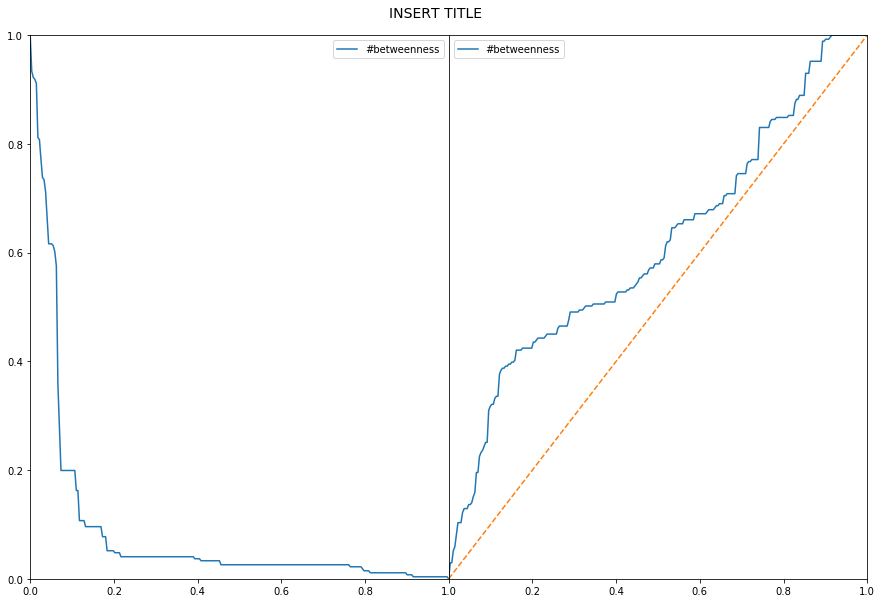

In [52]:
"""PLOTTING"""

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(node_frac, gc_list_by_degree, '-', label='#betweenness')
plt.ylim(top=1, bottom=0)
plt.xlim(left=0, right=1)
plt.legend()

plt.subplot(1,2,2)
plt.plot(node_frac,re_gc_list_by_degree, label='#betweenness')
plt.plot(node_frac, node_frac, '--')
plt.xlim(left=0, right=1)
plt.ylim(bottom=0, top=1)
plt.yticks([])
plt.xticks([0.2, 0.4, 0.6, 0.8, 1])
plt.legend()

plt.subplots_adjust(wspace=0)
plt.suptitle('INSERT TITLE', y=0.92, fontsize='14')
plt.show()

In [ ]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.90, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

In [ ]:
"""
def plot_degree_distribution (G) :
    degs = {}
    
    for n in G.nodes () :
        deg = G.degree (n)
        if deg not in degs :
            degs[deg] = 0
        degs[deg] += 1
    items = sorted (degs.items ())
    
    
    fig = plt.figure ()
    ax = fig.add_subplot (111)
    ax.plot([k for (k , v ) in items ],[v for (k, v) in items], 'o')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.title ("London Underground (Layer 1) Degree Distribution")
    #fig . savefig ( " degree_distribution . png " )
    
""";

In [ ]:
#PLOTTING DEGREE vs OTHER CENTRALITY MEASURES

In [ ]:
degree_list = list(G.degree())
degree_df = pd.DataFrame(degree_list, columns=['node', 'degree'])
degree_df.head()

In [ ]:
betweenness_list = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame(betweenness_list.items(), columns=['node', 'betweenness'])
betweenness_df.head()

In [ ]:
closeness_list = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(closeness_list.items(), columns=['node', 'closeness'])
closeness_df.head()

In [ ]:
eigen_list = eigen_c
#eigen_list = nx.eigenvector_centrality(G)
eigen_df = pd.DataFrame(eigen_list.items(), columns=['node', 'eigen'])
eigen_df.head()

In [ ]:
clus_list = nx.clustering(G)
clus_df = pd.DataFrame(clus_list.items(), columns=['node', 'clus'])


In [ ]:
deg_betw_df = pd.merge(degree_df, betweenness_df, on='node')
deg_close_df = pd.merge(degree_df, closeness_df, on='node')
deg_eigen_df = pd.merge(degree_df, eigen_df, on='node')
deg_clus_df = pd.merge(degree_df, clus_df, on='node')

In [ ]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.scatter(np.array(deg_betw_df.degree), np.array(deg_betw_df.betweenness))
plt.title('Degree vs Betweenness Centrality')
plt.xlabel('Degree')
plt.ylabel('Betweenness Centrality')

plt.subplot(2,2,2)
plt.scatter(np.array(deg_close_df.degree), np.array(deg_close_df.closeness))
plt.title('Degree vs Closeness Centrality')
plt.xlabel('Degree')
plt.ylabel('Closeness Centrality')

plt.subplot(2,2,3)
plt.scatter(np.array(deg_close_df.degree), np.array(deg_close_df.closeness))
plt.title('Degree vs Eigenvector Centrality')
plt.xlabel('Degree')
plt.ylabel('Eigenvector Centrality')

plt.subplot(2,2,4)
plt.scatter(np.array(deg_clus_df.degree), np.array(deg_clus_df.clus))
plt.title('Degree vs Clustering Coefficient')
plt.xlabel('Degree')
plt.ylabel('Clustering')

plt.suptitle('Layer 3 (DLR) // N_Nodes=45', y=0.94, fontsize=14)
plt.savefig('Layer_3_Degree_vs_Plot.pdf', format='pdf', dpi=1200)
plt.show()